In [1]:
from pydub import AudioSegment
from pydub.playback import play
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from sklearn.decomposition import FastICA, PCA
from numpy.linalg import inv
from scipy import signal
import IPython.display as ipd

/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/pydub/utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)
/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
# The audio files used are from http://cnl.salk.edu/~tewon/Blind/blind_audio.html
micA_file = 'tewon/rss_mA.wav'
micB_file = 'tewon/rss_mB.wav'
benchmarkSource1_file = 'tewon/sss1.wav'
benchmarkSource2_file = 'tewon/sss2.wav'

benchmarkSource1_sampleRate, benchmarkSource1_data = wavfile.read(benchmarkSource1_file)
enchmarkSource2_sampleRate, benchmarkSource2_data = wavfile.read(benchmarkSource2_file)

In [3]:
# Create mixed recordings from separated sources

mixed1_file = "mixedPydub1.wav"
mixed2_file = "mixedPydub2.wav"

audio1 = AudioSegment.from_file(benchmarkSource1_file) 
audio2 = AudioSegment.from_file(benchmarkSource2_file) 

louderAudio1 = audio1 + 6
quieterAudio1 = audio1 - 3.5
louderAudio2 = audio2 + 4
quieterAudio2 = audio2 - 1

mixed1 = louderAudio1.overlay(quieterAudio2)         
mixed2 = quieterAudio1.overlay(louderAudio2)    

mixed1.export(mixed1_file, format='wav') 
mixed2.export(mixed2_file, format='wav') 

<_io.BufferedRandom name='mixedPydub2.wav'>

In [4]:
def createMatrix(micA_file, micB_file):
    micA_sampleRate, micA_data = wavfile.read(micA_file)
    print("micA sample rate: {}".format(micA_sampleRate))
    print("micA samples: {}".format(micA_data))
    print("micA num samples: {}".format(len(micA_data)))
    
    micB_sampleRate, micB_data = wavfile.read(micB_file)
    print("micB sample rate: {}".format(micB_sampleRate))
    print("micB samples: {}".format(micB_data))
    print("micB num samples: {}".format(len(micB_data)))
    
    S = np.c_[micA_data, micB_data]
    print("concatenated samples:\n{}".format(S))
    return S, micA_sampleRate

def plotSignals(axarr, S, title):
    axarr.set_title(title)
    axarr.plot(S)
    
def runFastICA(Y):
    ica = FastICA(n_components=2)
    S_ = ica.fit_transform(Y)  # Reconstruct signals
    A_ = ica.mixing_
    print("A_:\n{}".format(ica.mixing_))
    print("mean_:\n{}".format(ica.mean_))
    print("np.dot(S_, A_.T):\n{}".format(np.dot(S_, A_.T)))
    assert np.allclose(Y, np.dot(S_, A_.T) + ica.mean_)

    return S_, A_

def writeExtractedSignals(S_, sampleRate, output1_file, output2_file):
    scaled1 = np.int16(S_[:,0]/np.max(np.abs(S_[:,0])) * 32767)
    wavfile.write(output1_file, sampleRate, scaled1)
    scaled2 = np.int16(S_[:,1]/np.max(np.abs(S_[:,1])) * 32767)
    wavfile.write(output2_file, sampleRate, scaled2)

micA sample rate: 16000
micA samples: [148 175 193 ... 258 258 294]
micA num samples: 119000
micB sample rate: 16000
micB samples: [159 141 159 ... 123 104 123]
micB num samples: 119000
concatenated samples:
[[148 159]
 [175 141]
 [193 159]
 ...
 [258 123]
 [258 104]
 [294 123]]


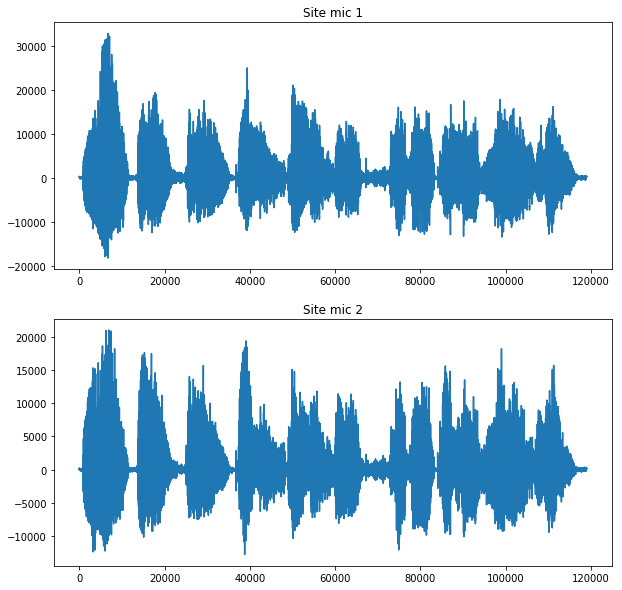

In [5]:
# Plot mixed signals from site
site_Y, site_sampleRate = createMatrix(micA_file, micB_file)
fig, axarr = plt.subplots(2, 1, figsize=(10, 10)) 
plotSignals(axarr[0], site_Y[:,0], "Site mic 1")
plotSignals(axarr[1], site_Y[:,1], "Site mic 2")
plt.show()

In [6]:
site_S_, site_A_ = runFastICA(site_Y)
site_separated1_file = 'separatedSite1.wav'
site_separated2_file = 'separatedSite2.wav'
writeExtractedSignals(site_S_, site_sampleRate, site_separated1_file,site_separated2_file)

A_:
[[ -389152.90936358 -1348836.61290078]
 [  493094.26218538  -986002.8620495 ]]
mean_:
[-0.50131933 -0.50063866]
np.dot(S_, A_.T):
[[148.50131933 159.50063866]
 [175.50131933 141.50063866]
 [193.50131933 159.50063866]
 ...
 [258.50131933 123.50063866]
 [258.50131933 104.50063866]
 [294.50131933 123.50063866]]


In [7]:
ipd.Audio(site_separated1_file)

In [8]:
ipd.Audio(site_separated2_file)

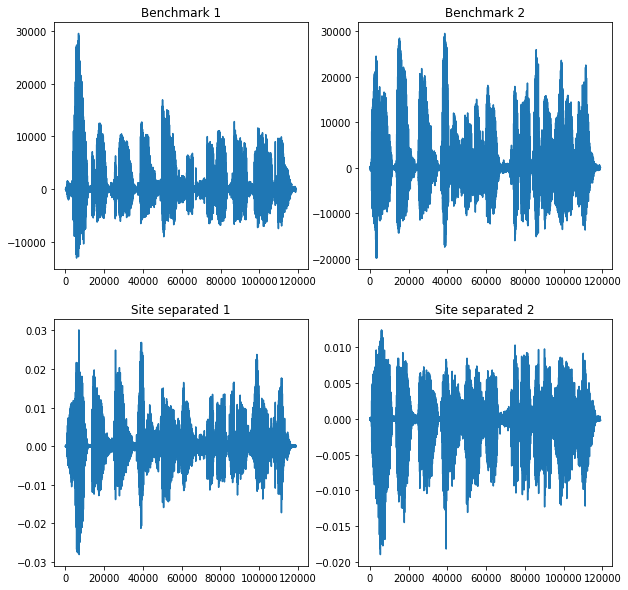

In [9]:
# Plot signals from site and benchmarks
fig, axarr = plt.subplots(2, 2, figsize=(10, 10)) 
plotSignals(axarr[0][0], benchmarkSource1_data, "Benchmark 1")
plotSignals(axarr[0][1], benchmarkSource2_data, "Benchmark 2")
plotSignals(axarr[1][0], site_S_[:,0], "Site separated 1")
plotSignals(axarr[1][1], site_S_[:,1], "Site separated 2")
plt.show()

micA sample rate: 16000
micA samples: [11 11 11 ... 18 19 22]
micA num samples: 118976
micB sample rate: 16000
micB samples: [-4 -4 -4 ... 25 27 28]
micB num samples: 118976
concatenated samples:
[[11 -4]
 [11 -4]
 [11 -4]
 ...
 [18 25]
 [19 27]
 [22 28]]


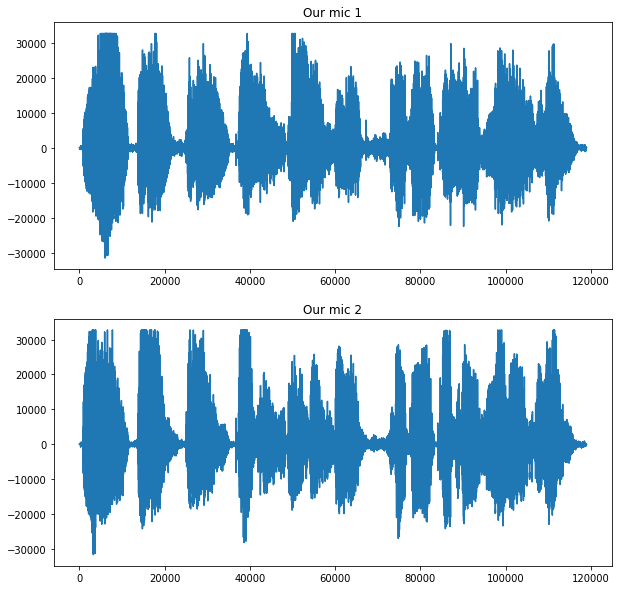

In [10]:
# Plot mixed signals we created
our_Y, our_sampleRate = createMatrix(mixed1_file, mixed2_file)
fig, axarr = plt.subplots(2, 1, figsize=(10, 10)) 
plotSignals(axarr[0], our_Y[:,0], "Our mic 1")
plotSignals(axarr[1], our_Y[:,1], "Our mic 2")
plt.show()

In [11]:
our_S_, our_A_ = runFastICA(our_Y)
mixed_separated1_file = 'separatedMixed1.wav'
mixed_separated2_file = 'separatedMixed2.wav'
writeExtractedSignals(our_S_, our_sampleRate, mixed_separated1_file, mixed_separated2_file)

A_:
[[-1366645.27633889  1926222.65970172]
 [-2457088.92551972   668478.67981147]]
mean_:
[-21.18230568  -8.91159562]
np.dot(S_, A_.T):
[[32.18230568  4.91159562]
 [32.18230568  4.91159562]
 [32.18230568  4.91159562]
 ...
 [39.18230568 33.91159562]
 [40.18230568 35.91159562]
 [43.18230568 36.91159562]]


In [12]:
ipd.Audio(mixed_separated1_file)

In [13]:
ipd.Audio(mixed_separated2_file)

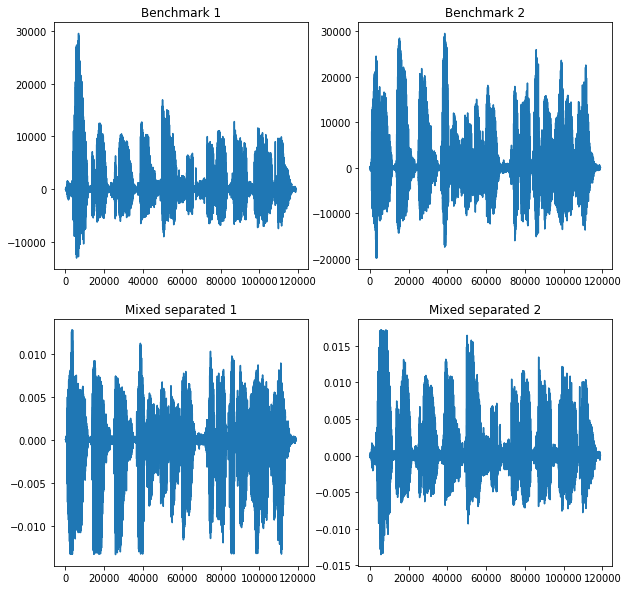

In [14]:
# Plot signals from our mixed files and benchmarks
fig, axarr = plt.subplots(2, 2, figsize=(10, 10)) 
plotSignals(axarr[0][0], benchmarkSource1_data, "Benchmark 1")
plotSignals(axarr[0][1], benchmarkSource2_data, "Benchmark 2")
plotSignals(axarr[1][0], our_S_[:,0], "Mixed separated 1")
plotSignals(axarr[1][1], our_S_[:,1], "Mixed separated 2")
plt.show()

In [15]:
#Analysis
micA_sampleRate, micA_data = wavfile.read(micA_file)
micB_sampleRate, micB_data = wavfile.read(micB_file)
mixed1_sampleRate, mixed1_data = wavfile.read(mixed1_file)
mixed2_sampleRate, mixed2_data = wavfile.read(mixed2_file)
print("len of benchmarkSource1: {}".format(len(benchmarkSource1_data)))
print("len of benchmarkSource2: {}".format(len(benchmarkSource2_data)))
print("len of micA_data: {}".format(len(micA_data)))
print("len of micB_data: {}".format(len(micB_data)))
print("len of mixed1_data: {}".format(len(mixed1_data)))
print("len of mixed2_data: {}".format(len(mixed2_data)))
print(len(micA_data) - len(benchmarkSource1_data))

len of benchmarkSource1: 118976
len of benchmarkSource2: 118976
len of micA_data: 119000
len of micB_data: 119000
len of mixed1_data: 118976
len of mixed2_data: 118976
24


In [16]:
micA_data_centered = micA_data - micA_data.mean()
micB_data_centered = micB_data - micB_data.mean()
benchmarkSource1_data_centered = benchmarkSource1_data - benchmarkSource1_data.mean()
benchmarkSource2_data_centered = benchmarkSource2_data - benchmarkSource2_data.mean()
mixed1_data_centered = mixed1_data - mixed1_data.mean()
mixed2_data_centered = mixed2_data - mixed2_data.mean()

/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


3

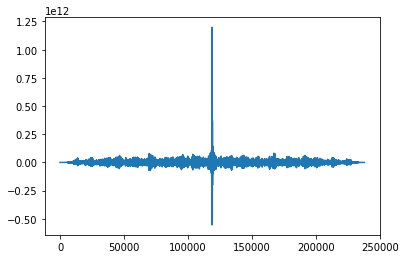

In [17]:
corrs = signal.correlate(micA_data_centered, micB_data_centered)
plt.plot(corrs)
np.argmax(corrs) - len(micA_data_centered) + 1

/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


lag: 3


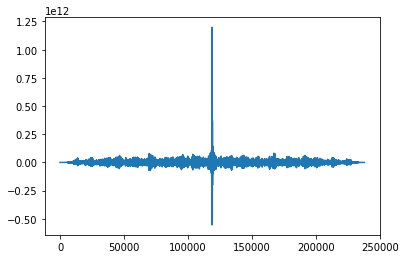

In [18]:
# Cross correlation between the site's mic 1 and mic 2
corrs = signal.correlate(micA_data_centered, micB_data_centered)
plt.plot(corrs)
micB_lag = np.argmax(corrs) - len(micA_data_centered) + 1
print("lag: {}".format(micB_lag))

/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


0

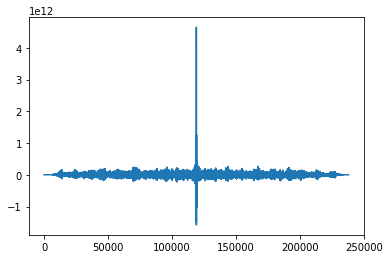

In [19]:
# Cross correlation between the our mixed 1 and mixed 2
corrs = signal.correlate(mixed1_data_centered, mixed2_data_centered)
plt.plot(corrs)
np.argmax(corrs) - len(mixed1_data_centered) + 1

[159 141 159 196 214 123 196 178 123 141]
[123 104 123 159 141 159 196 214 123 196]
lag: 0


/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


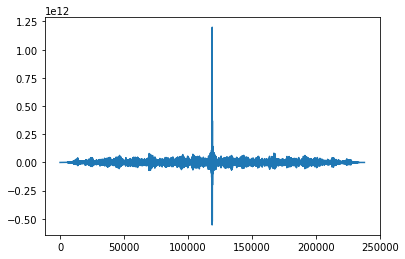

In [20]:
# Try correcting for delay
rolled_micB_data = np.roll(micB_data, shift=int(np.ceil(micB_lag)))
print(micB_data[:10])
print(rolled_micB_data[:10])
rolled_micB_data_centered = rolled_micB_data - rolled_micB_data.mean()
corrs = signal.correlate(micA_data_centered, rolled_micB_data_centered)
plt.plot(corrs)
micB_lag = np.argmax(corrs) - len(micA_data_centered) + 1
print("lag: {}".format(micB_lag))

In [21]:
corrected_Y = np.c_[micA_data, rolled_micB_data]
corrected_S_, corrected_A_ = runFastICA(corrected_Y)
corrected_site_separated1_file = 'corrected_separatedSite1.wav'
corrected_site_separated2_file = 'corrected_separatedSite2.wav'
writeExtractedSignals(corrected_S_, site_sampleRate, corrected_site_separated1_file, corrected_site_separated2_file)

A_:
[[-893228.54818969 1083024.91008598]
 [  -5488.08743168 1102412.57080382]]
mean_:
[-0.50131933 -0.50063866]
np.dot(S_, A_.T):
[[148.50131933 123.50063866]
 [175.50131933 104.50063866]
 [193.50131933 123.50063866]
 ...
 [258.50131933 159.50063866]
 [258.50131933 104.50063866]
 [294.50131933  86.50063866]]


In [22]:
ipd.Audio(corrected_site_separated1_file)

In [23]:
ipd.Audio(corrected_site_separated2_file)

In [24]:
# Try correcting for delay the other way
print(micB_lag)
rolled_micA_data = np.roll(micA_data, shift=-micB_lag)
print(micA_data[:10])
print(micA_data[:-10])
print(rolled_micA_data[:10])

0
[148 175 193 221 230 148 166 230 157 193]
[148 175 193 ... 258 304 294]
[148 175 193 221 230 148 166 230 157 193]


In [25]:
corrected2_Y = np.c_[rolled_micA_data, micB_data]
corrected2_S_, corrected2_A_ = runFastICA(corrected_Y)
corrected2_site_separated1_file = 'corrected2_separatedSite1.wav'
corrected2_site_separated2_file = 'corrected2_separatedSite2.wav'
writeExtractedSignals(corrected2_S_, site_sampleRate, corrected2_site_separated1_file, corrected2_site_separated2_file)

A_:
[[ 831074.59336375 1131421.76726148]
 [ -56355.7423407  1100984.84352655]]
mean_:
[-0.50131933 -0.50063866]
np.dot(S_, A_.T):
[[148.50131933 123.50063866]
 [175.50131933 104.50063866]
 [193.50131933 123.50063866]
 ...
 [258.50131933 159.50063866]
 [258.50131933 104.50063866]
 [294.50131933  86.50063866]]


In [26]:
ipd.Audio(corrected2_site_separated1_file)

In [27]:
ipd.Audio(corrected2_site_separated2_file)